<a href="https://colab.research.google.com/github/rothn/P1P2Adapter/blob/main/probability-assignment-evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoscape Fraud Detection Evals

Notebook Purpose: Eval isoscape generation methods for our paper

Task: Compute the precision and recall of fraud detection by probability assignment (e.g. assignR), with calibration performed by thresholding.

# Setup

## Fetch Dependencies

In [1]:
!pip install rasterio fiona pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 12.0 MB/s eta 0:00:00


## Import libraries required

In [2]:
import importlib
from datetime import datetime
import sys
import os

In [3]:
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 7.36 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (7/7), done.
executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


In [4]:
import train_variational_inference_model as tvim
import raster
import eeddf
import dataset
import fiona
import rasterio.mask
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount(raster.GDRIVE_BASE)

# Leave test_environment=True. Experiments must be done in test.
eeddf.initialize_ddf(test_environment=True)

Mounted at /content/gdrive


In [5]:
# Patch https://github.com/tnc-br/ddf_common/issues/72 here
import evaluation
importlib.reload(evaluation)
importlib.reload(tvim)
import evaluation

# Data configuration

In [137]:
# REQUIREMENTS:

# 1) Column names must match features_to_standardize, features_to_passthrough
# 2) Label columns in particular must match var_label and mean_label.
#
# If you used the data ingestion notebook (ingestion.ipynb) then this
# should be set up for you already.

# TRAINING FILE PARAMS
DATABASE_DIR = raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE
TRAINING_SET_FILE = 'canonical/12_16_filtered_train_random_iid_nonan.csv' #@param
VALIDATION_SET_FILE = 'canonical/12_16_filtered_validation_random_iid_nonan.csv' #@param
TEST_SET_FILE = 'canonical/12_16_filtered_test_random_iid_nonan.csv' #@param

# EVAL FILE PARAMS
EVAL_DATASET = 'canonical/12_16_filtered_test_random_iid_nonan.csv' #@param
#ORIGINAL_DATASET = 'canonical/2023_07_27_Results_google_utf8_latlonadded.csv' #@param
ORIGINAL_DATASET = 'canonical/12_16_ungrouped.csv' #@param


fileset = {
    'TRAIN' : os.path.join(DATABASE_DIR, TRAINING_SET_FILE),
    'TEST' : os.path.join(DATABASE_DIR, TEST_SET_FILE),
    'VALIDATION' : os.path.join(DATABASE_DIR, VALIDATION_SET_FILE),
    'EVAL' : os.path.join(DATABASE_DIR, EVAL_DATASET),
    'ORIGINAL' : os.path.join(DATABASE_DIR, ORIGINAL_DATASET)
}


with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/bra_adm_ibge_2020_shp.zip') as shp:
  BRAZIL_SHP_MASK = [feature["geometry"] for feature in shp]

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/Amazon Biome.zip/data/commondata/data0') as shp:
  AMAZON_SHP_MASK = [feature["geometry"] for feature in shp]

# Load these lazily later from the first generated isoscapes

def display_brazil(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, BRAZIL_SHP_MASK, crop=False)
    out_meta = src.meta
    brazil_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, brazil_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

def display_amazon(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, AMAZON_SHP_MASK, crop=False)
    out_meta = src.meta
    amazon_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, amazon_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

# External Isoscape (Autokrige)

In [11]:
means_raster = raster.load_raster(f'{DATABASE_DIR}/../amazon_rasters/gabi_iso_d18O_wood_map_random_iid_split.tiff')
vars_raster = raster.load_raster(f'{DATABASE_DIR}/../amazon_rasters/gabi_iso_d18O_wood_map_random_iid_split_var.tiff')

/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Driver: GTiff/GeoTIFF
Size is 1476 x 1024 x 1
Projection is PROJCS["SIRGAS 2000 / Brazil Polyconic",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4674"]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5880"]]
Origin = (-73.98318215899995, 5.269580833000035)
Pixel Size = (0.02072077522493222, -0.021417577473632765)
Driver: GTiff/GeoTIFF
Size is 1476 x 1024 x 1
Projection is PROJCS["SIRGAS 2000 / Brazil Polyconic",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",

In [151]:
import scipy.stats

# Computes a PDF given a 2D geospatial mean and variance raster, and a sample
def compute_pdf(sample, means_raster, var_raster):
  pdf = scipy.stats.norm.pdf(x=sample, loc=means_raster.yearly_masked_image.data, scale=np.sqrt(vars_raster.yearly_masked_image.data))
  pdf /= np.nansum(pdf)
  return pdf

def compute_probability_not_in_mask(sample: float, allowed_mask: np.array, means_raster: raster.AmazonGeoTiff, var_raster: raster.AmazonGeoTiff):
  pdf = compute_pdf(sample, means_raster, var_raster)
  bounds = raster.get_extent(means_raster.gdal_dataset)
  return 1 - float(np.nansum(np.multiply(pdf, allowed_mask)))

import dataclasses

@dataclasses.dataclass
class LatLon:
  lat: float
  long: float

def coords_to_indices(bounds: raster.Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    #raise ValueError("Coordinates out of bounds")
    return None, None

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def compute_radius_mask(center: LatLon, radius_km: float, raster_bounds: raster.Bounds) -> np.array:
  x_idx, y_idx = raster.coords_to_indices(raster_bounds, center.long, center.lat) # lat and long are flipped here
  # Equation: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance
  # Latitude: 1 deg = 110.574 km
  # Longitude: 1 deg = 111.320*cos(latitude) km
  # in GDAL, x is long, y is lat
  lat_radius_deg = (1 / 110.574) * radius_km
  long_radius_deg = (1 / (111.320 * np.cos(np.radians(center.lat)))) * radius_km
  lat_radius_px = lat_radius_deg / raster_bounds.pixel_size_y
  long_radius_px = long_radius_deg / raster_bounds.pixel_size_x
  x = np.linspace(0, means_raster.yearly_masked_image.data.shape[0], means_raster.yearly_masked_image.data.shape[0])
  y = np.linspace(0, means_raster.yearly_masked_image.data.shape[1], means_raster.yearly_masked_image.data.shape[1])[:,None]
  ellipse_mask = ((x-x_idx)/long_radius_px)**2 + ((y-y_idx)/lat_radius_px)**2 <= 1
  return ellipse_mask.T

def compute_probability_not_in_radius(center: LatLon, radius_km: float, sample: float, means_raster: raster.AmazonGeoTiff, var_raster: raster.AmazonGeoTiff) -> float:
  bounds = raster.get_extent(means_raster.gdal_dataset)
  allowed_mask = compute_radius_mask(center, radius_km, bounds)
  p_fraud = compute_probability_not_in_mask(sample, allowed_mask, means_raster, var_raster)
  return p_fraud

In [154]:
compute_probability_not_in_radius(LatLon(lat=-8.625, long=-62.852), radius_km=500, sample=26.446, means_raster=means_raster, var_raster=vars_raster)

0.8206366492307413

In [161]:
raw_test = pd.concat([pd.read_csv(fileset['TEST']), pd.read_csv(fileset['VALIDATION'])], join='outer', ignore_index=True, axis=0)

In [188]:
import random
random.seed(42)
np.random.seed(42)
fraud_mask = np.zeros(raw_test.shape[0], dtype=bool)
fraud_mask[:int(raw_test.shape[0]/2)] = True
np.random.shuffle(fraud_mask)

fraud_coords = raw_test[fraud_mask][['lat', 'long']].to_numpy()
np.random.shuffle(fraud_coords)
fraud_samples = raw_test[fraud_mask]['d18O_cel_mean']

non_fraud_coords = raw_test[np.logical_not(fraud_mask)][['lat', 'long']].to_numpy()
non_fraud_samples = raw_test[np.logical_not(fraud_mask)]['d18O_cel_mean']

In [196]:
fraud_scores_for_legit_samples = []
for coords, sample in zip(non_fraud_coords, non_fraud_samples):
  fraud_scores_for_legit_samples.append(compute_probability_not_in_radius(LatLon(lat=coords[0], long=coords[1]), radius_km=500, sample=sample, means_raster=means_raster, var_raster=vars_raster))

In [195]:
fraud_scores_for_fraud_samples = []
for coords, sample in zip(fraud_coords, fraud_samples):
  fraud_scores_for_fraud_samples.append(compute_probability_not_in_radius(LatLon(lat=coords[0], long=coords[1]), radius_km=500, sample=sample, means_raster=means_raster, var_raster=vars_raster))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2046: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [197]:
np.mean(fraud_scores_for_legit_samples)

np.float64(0.956160751810468)

In [198]:
np.mean(fraud_scores_for_fraud_samples)

np.float64(0.9544962271860069)

### Testing

In [162]:
raw_test

,Unnamed: 0,Code,lat,long,d13C_foliar,d15N_foliar,d15N_soil,VPD,RH,PET,...,Iso_Oxi_Stack_mean_TERZER,brisoscape_mean_ISORIX,d13C_cel_mean,d13C_cel_var,ordinary_kriging_linear_d18O_predicted_mean,ordinary_kriging_linear_d18O_predicted_variance,isoscape_fullmodel_d18O_prec_REGRESSION,d18O_cel_count,d18O_cel_mean,d18O_cel_variance
0,165,mad710,-8.625000,-62.852000,-27.939159,5.142177,8.599729,0.618330,0.819810,91.075000,...,-4.847430,-4.827298,-26.739805,0.187934,25.109094,0.869067,-4.849006,5,26.446000,1.101230
1,242,mad84,-3.398397,-54.973982,-27.441160,5.768528,9.537585,0.645000,0.817440,97.933330,...,-3.563810,-3.536935,-26.485288,0.119047,26.124869,0.788921,-3.426293,5,26.220000,0.532750
2,1,mad1,-3.995545,-57.589273,-28.992315,4.894455,9.003261,0.851670,0.773580,99.991670,...,-3.789670,-3.789665,-27.921725,0.033721,26.097423,0.714389,-3.730411,5,26.748000,0.532670
3,57,mad504,-0.903610,-60.434060,-27.436941,3.884906,7.983244,0.775830,0.789360,99.883330,...,-3.861750,-3.861751,-26.286357,0.010363,26.934909,0.692864,-3.873132,5,27.268000,1.472320
4,156,mad681,-8.629000,-70.139000,-27.881550,3.513474,7.645183,0.607500,0.816430,86.633330,...,-5.505650,-5.509349,-26.697662,0.033222,24.273986,1.671995,-5.903159,4,25.125000,0.100567
5,137,mad664,-8.657000,-70.196000,-27.726097,3.376237,7.802597,0.605000,0.816710,86.691670,...,-5.530040,-5.527658,-26.558505,0.046473,24.259409,1.689851,-5.903159,5,28.393175,4.229251
6,158,mad683,-8.649000,-70.158000,-27.881550,3.513474,7.634297,0.607500,0.816430,86.633330,...,-5.505650,-5.509349,-26.697662,0.033222,24.273986,1.671995,-5.903159,5,24.556000,1.000080
7,110,mad64,-2.495000,-59.122000,-27.656116,4.140200,8.005235,0.775000,0.788660,98.450000,...,-3.981930,-3.981933,-26.380854,0.028848,25.503040,0.661004,-3.840096,5,26.532000,2.731520
8,106,mad636,-9.294000,-62.981000,-27.684219,5.238959,9.128089,0.633330,0.814160,91.683330,...,-4.901630,-4.901631,-26.468999,0.135008,25.140820,0.747942,-4.927781,4,25.407500,0.877558
9,123,mad651,-9.304000,-63.031000,-27.647158,5.019513,8.606969,0.634170,0.814130,91.800000,...,-4.908000,-4.908004,-26.435323,0.151784,25.129123,0.771505,-4.941418,5,23.434000,0.346830


In [166]:
len(raw_test.columns) == len(pd.read_csv(fileset['TEST']).columns)

True

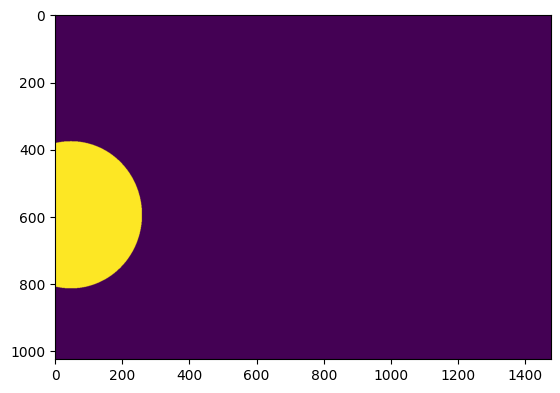

In [155]:
from matplotlib import pyplot as plt

plt.imshow(compute_radius_mask(center=LatLon(lat=-7.5, long=-73), radius_km=500, raster_bounds=raster.get_extent(means_raster.gdal_dataset)))

In [116]:
from matplotlib import rc
rc('animation', html='jshtml')

In [ ]:
plt.imshow(means_raster.yearly_masked_image.data)

In [ ]:
raster.animate(means_raster,  1, 1)

In [ ]:
!head {DATABASE_DIR}{EVAL_DATASET}

Unnamed: 0,Code,lat,long,d13C_foliar,d15N_foliar,d15N_soil,VPD,RH,PET,DEM,PA,Mean Annual Temperature,Mean Annual Precipitation,Iso_Oxi_Stack_mean_TERZER,brisoscape_mean_ISORIX,d13C_cel_mean,d13C_cel_var,ordinary_kriging_linear_d18O_predicted_mean,ordinary_kriging_linear_d18O_predicted_variance,isoscape_fullmodel_d18O_prec_REGRESSION,d18O_cel_count,d18O_cel_mean,d18O_cel_variance
165,mad710,-8.625,-62.852,-27.93915939,5.142177105,8.599728584,0.61833,0.81981,91.075,157,994.23041,25.50833,2311,-4.84743,-4.827298164,-26.73980459,0.1879344384,25.10909423,0.8690671381,-4.849006335,5,26.446,1.10123
242,mad84,-3.3983972,-54.973982,-27.4411602,5.768527985,9.537585258,0.645,0.81744,97.93333,139,996.36792,26.0,1840,-3.56381,-3.536934853,-26.48528798,0.1190467775,26.12486882,0.7889210593,-3.4262927373250327,5,26.22,0.5327500000000008
1,mad1,-3.995544837,-57.58927257,-28.99231529,4.894455433,9.003260612,0.85167,0.77358,99.99167,61,1005.67358,27.16667,2273,-3.78967,-3.789665222,-27.92172496,0.033720

In [ ]:

res = evaluation.evaluate(means_raster, vars_raster,
                  pd.read_csv(f'{DATABASE_DIR}{ORIGINAL_DATASET}'),
                   ['d18O_cel'],
                  eval_dataset=pd.read_csv(f'{DATABASE_DIR}{EVAL_DATASET}'),
                  mean_label="d18O_cel_mean",
                  var_label="d18O_cel_variance",
                  sample_size_per_location=5,
                  precision_target=0.95,
                  recall_target=None,
                  start_max_fraud_radius=6,
                  end_max_fraud_radius=3000,
                  radius_pace=100,
                  trusted_buffer_radius=5)

Text(0.5, 0, 'Simulated Fraud Radius (km)')

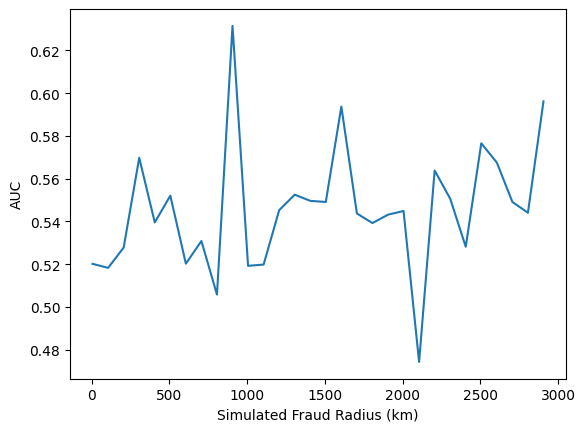

In [ ]:
#x = np.array([x['radius'] for x in res.rmse['per_radius_eval']])
#y = np.array([x['auc'] for x in res.rmse['per_radius_eval']])
x = np.array(list(res.auc_scores.keys()))
y = np.array(list(res.auc_scores.values()))
plt.plot(x, y, label='AUC')
if False:
    spl = UnivariateSpline(x, y, s=1)
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = spl(x_smooth)
    plt.plot(x_smooth, y_smooth, 'g-', lw=3, label='Smoothed')
plt.ylabel('AUC')
plt.xlabel('Simulated Fraud Radius (km)')

In [ ]:
res.rmse

{'mean_rmse': 1.1800431907236404,
 'var_rmse': 1.3382402919081664,
 'overall_rmse': 1.2591417413159034}

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

means_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=0)
raster.animate(means_isoscape,  1, 1)

In [ ]:
vars_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=1)
raster.animate(vars_isoscape,  1, 1)